In [1]:
import torch
import torch.nn.functional as F
import os
from models import Siren, weights_init
from utils import multilabel_sdm, evaluate, visualize_differences
from functools import partial
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange, tqdm
import json
import numpy as np

import matplotlib.pyplot as plt


In [2]:
seg = torch.load('/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/data/ring_example_img.pth').permute(0, 2, 3, 1)
pts = torch.load('/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/data/ring_example_pts.pth')

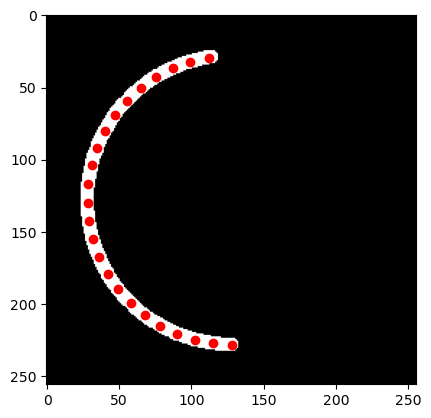

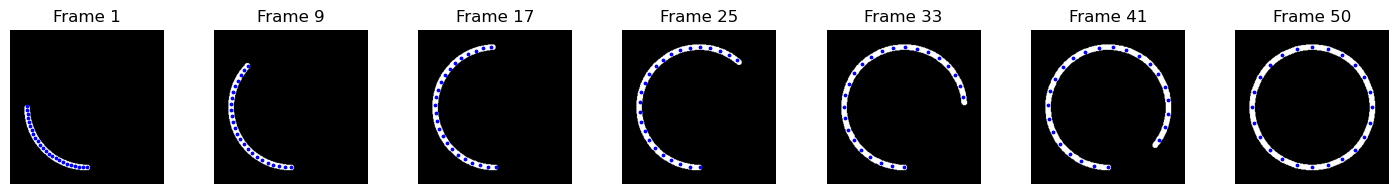

In [3]:
#idx = torch.randperm(seg.size(0))
idx =15
plt.imshow(seg[idx], 'gray')
plt.scatter(pts[idx+1, :, 0], pts[idx+1, :, 1], c='r')
plt.show()


#plot those

fig, ax = plt.subplots(1, 7, figsize=(18, 2))
for ii,i in enumerate(np.linspace(0, 49, 7).astype(int)):
    ax[ii].imshow(seg[i], 'gray')
    if i != 49:
        ax[ii].scatter(pts[i+1, :, 0], pts[i+1, :, 1], c='b', s=3)

    else:
        ax[ii].scatter(pts[i, :, 0], pts[i, :, 1], c='b', s=3)
    ax[ii].axis('off')
    ax[ii].set_title(f'Frame {i+1}')
plt.show()


#save these frames as images
for ii,i in enumerate(np.linspace(0, 49, 7).astype(int)):
    plt.imshow(seg[i], 'gray')
    if i != 49 or i ==0: #color tab10 blue
        plt.scatter(pts[i+1, :, 0], pts[i+1, :, 1], c='r', s=50)
    else:
        plt.scatter(pts[i, :, 0], pts[i, :, 1], c='r', s=50)
    plt.axis('off')
    #plt.savefig(f'/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/toy_example/ring_example_{ii}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

In [4]:
import torch.nn as nn

class SirenModulated(nn.Module):
    def __init__(self,in_features, out_features, hidden_ch=256,scale=30,num_layers=3):
        super().__init__()
        self.scale = scale
        self.hidden_ch = hidden_ch
        listnet = [nn.Linear(2,hidden_ch)]
        modulation_listnet = []
        for i in range(num_layers):
            listnet.append(nn.Linear(hidden_ch,hidden_ch))
            modulation_listnet.append(nn.Linear(in_features-2,hidden_ch*2))
        listnet.append(nn.Linear(hidden_ch,out_features))
        self.net = nn.Sequential(*listnet)
        self.mod = nn.Sequential(*modulation_listnet)
        

    def forward(self,x):
        latent_code = x[...,2:]
        scale = self.scale
        hdim = self.hidden_ch
        y = torch.sin(scale*self.net[0](x[...,:2]))
        for i in range(1,len(self.net)-1):
            phi_psi = self.mod[i-1](latent_code)
            y = torch.sin(scale*(phi_psi[...,:hdim]*self.net[i](y))+phi_psi[...,hdim:])
        return self.net[-1](y)

In [6]:
#choose trained model

#model_path = '/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/results/17-playful-valley'
model_path = '/home/grossbroehmer/storage/staff/fenjafalta_658025/INR-SSM/results/111-occult-ghost/'
#read config in args.json
with open(os.path.join(model_path, 'args.json'), 'r') as f:
    args = json.load(f)

#initialize model
#def __init__(self,in_features, out_features, hidden_ch=256,scale=30,num_layers=3):


if args['model'] == 'SirenModulated':
    model = SirenModulated(in_features=2+args['codebook_sz'], out_features=1, hidden_ch=args['channels'], num_layers=args['layers'])
else:
    model = Siren(in_features=2+args['codebook_sz'], out_features=1, hidden_ch=args['channels'], num_layers=args['layers'])
#load model
optimized_data = torch.load(os.path.join(model_path, f'model_{str(args["epochs"]-1)}.pth'))
model.load_state_dict(optimized_data['model'])

latent_codes = optimized_data['codebook'].detach().cpu()
N = args['num_samples']
H,W,C = seg.shape[-3:]
mesh = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W))

/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


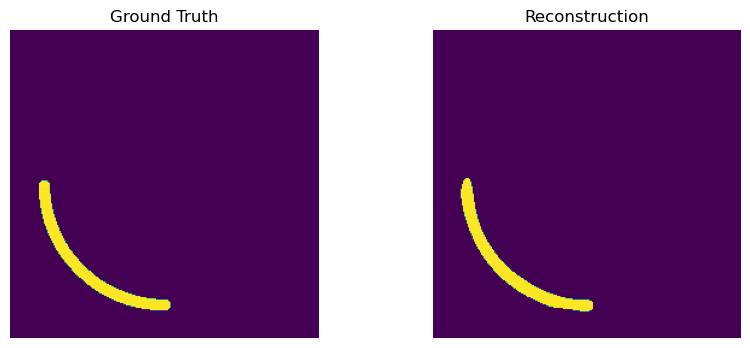

In [7]:
with torch.no_grad():
    out = model(torch.cat([mesh.view(-1,2), latent_codes[0].unsqueeze(0).repeat(H*W,1)], dim=-1)).view(H,W,1)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(seg[0,:,:].sum(-1))
ax[0].title.set_text('Ground Truth')
ax[1].imshow((out[:,:]<0).sum(-1).cpu())
ax[1].title.set_text('Reconstruction')
for a in ax:
    a.axis('off')
plt.show()

/tmp/ipykernel_703963/3020233732.py:7: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/aten/src/ATen/native/Copy.cpp:301.)
  eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)


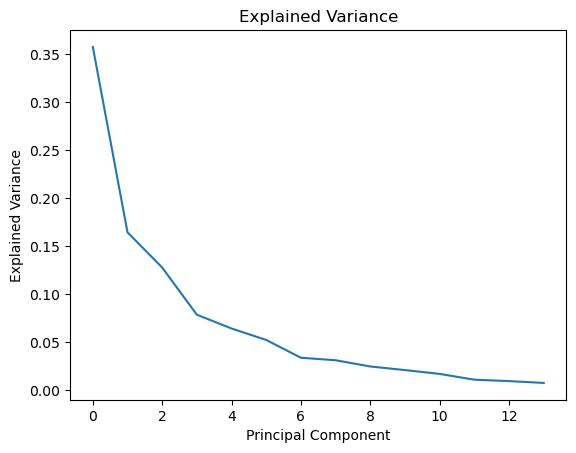

In [8]:

mean_shape = latent_codes.mean(dim=0)

cov_matrix = torch.matmul((latent_codes - mean_shape).T, (latent_codes - mean_shape)) / latent_codes.shape[0]

eigenvalues_, eigenvectors_ = torch.linalg.eig(cov_matrix)

eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)
eigenvectors_ = eigenvectors_[:, indices].float()


plt.plot(eigenvalues_/eigenvalues_.sum())
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')
plt.show()

In [9]:
num_steps = 7
steps = torch.linspace(1,-1,num_steps)
b = torch.zeros(latent_codes.shape[1])
images_seg_ring = []

for ii,ev1 in enumerate(steps):

    b[0] = ev1 * torch.sqrt(eigenvalues_[0])
    latent_code = mean_shape + torch.matmul(eigenvectors_, b)
    
    with torch.no_grad():
        out = model(torch.cat([mesh.view(-1,2), latent_code.unsqueeze(0).repeat(H*W,1)], dim=-1)).view(H,W,1)
        out = (out[:,:]<0).sum(-1).cpu()
    images_seg_ring.append(out)

    #save these frames as images
    plt.imshow(out, 'gray')
    plt.axis('off')

    plt.savefig(f'/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/toy_example2/ring_example_recon{ii}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()


In [169]:
# ##generate gif from images
# import imageio
# imageio.mimsave('../visual_results/pca_ring_inr_ev1.gif', [i.float()*255 for i in images], duration=0.3)


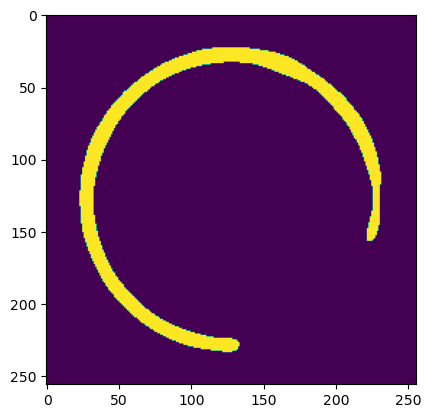

In [10]:
plt.imshow(images_seg_ring[0])

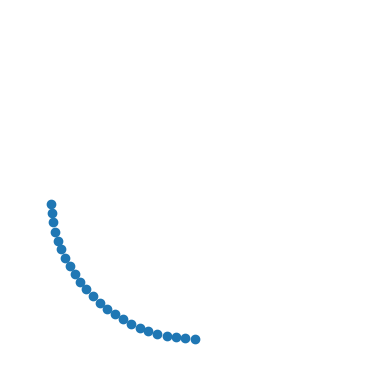

In [11]:
pts.shape

plt.scatter(pts[0,:,0], pts[0,:,1])
#set axis to 0,256
plt.xlim(0,256)
plt.ylim(0,256)
#equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
#reverse y-axis
plt.gca().invert_yaxis()
#remove axis
plt.axis('off')
plt.show()

torch.Size([50, 24, 2])


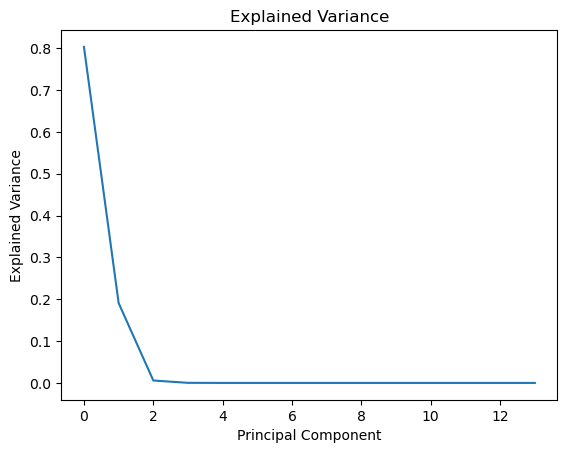

In [12]:
print(pts.shape)
pts_ =pts.reshape(50,-1)

##perform pca
mean_shape = pts_.mean(dim=0)

cov_matrix = torch.matmul((pts_ - mean_shape).T, (pts_ - mean_shape)) / pts_.shape[0]

eigenvalues_, eigenvectors_ = torch.linalg.eig(cov_matrix)

eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)
eigenvectors_ = eigenvectors_[:, indices].float()

plt.plot((eigenvalues_/eigenvalues_.sum())[:14])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')
plt.show()


In [13]:

num_steps = 7
steps = torch.linspace(-1,1,num_steps)
b = torch.zeros(pts_.shape[1])
shapes = []

for ev1 in steps:
    
        b[0] = ev1 * torch.sqrt(eigenvalues_[0])
        appr_shape = mean_shape + torch.matmul(eigenvectors_, b)
        appr_shape = appr_shape.reshape(-1,2)
        shapes.append(appr_shape)


# for i in trange(3):
#         #plot images and save them as pngs
#         plt.scatter(shapes[i][:,0], shapes[i][:,1])
#         plt.xlim(0,256)
#         plt.ylim(0,256)
#         plt.gca().set_aspect('equal', adjustable='box')
#         plt.gca().invert_yaxis()
#         plt.axis('off')
#         plt.show()
#         #plt.savefig(f'../tmp/pca_ring_kpts_ev1/pca_ring_kpts_{str(i).zfill(3)}.png', bbox_inches='tight')
#         #plt.close()

#generate gif
#import imageio
#imageio.mimsave('../visual_results/pca_ring_kpts_ev1.gif', [imageio.imread(f'../tmp/pca_ring_kpts_ev1/pca_ring_kpts_{str(i).zfill(3)}.png') for i in range(50)], duration=0.3)


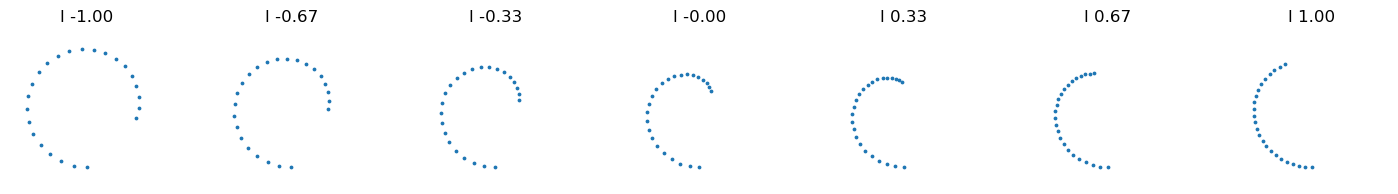

In [15]:

fig, ax = plt.subplots(1, 7, figsize=(18, 2))
for ii,i in enumerate(range(7)):
#     ax[ii].imshow(seg[i], 'gray')
#     if i != 49:
#         ax[ii].scatter(pts[i+1, :, 0], pts[i+1, :, 1], c='r', s=3)

#     else:
#         ax[ii].scatter(pts[i, :, 0], pts[i, :, 1], c='r', s=3)
#     ax[ii].axis('off')
#     ax[ii].set_title(f'Frame {i+1}')
# plt.show()
    ax[ii].scatter(shapes[i][:,0], shapes[i][:,1], s=3)
    ax[ii].set_xlim(0,256)
    ax[ii].set_ylim(0,256)
    ax[ii].set_aspect('equal', adjustable='box')
    ax[ii].invert_yaxis()
    ax[ii].axis('off')
    ax[ii].set_title(f'l {steps[i]:.2f}')
    #make frame around plot
plt.show()


#save these frames as images
for ii,i in enumerate(range(7)):
    plt.scatter(shapes[i][:,0], shapes[i][:,1], s=50)
    plt.xlim(0,256)
    plt.ylim(0,256)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(f'/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/toy_example2/ring_example_kpts_{ii}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()
    

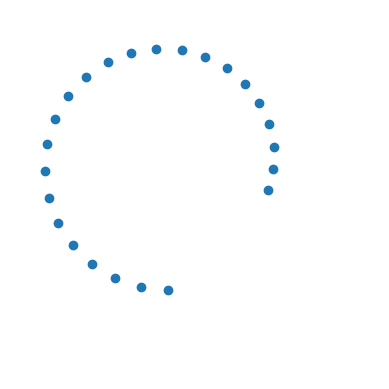

In [16]:
shapes[0]
#scatter plot of first shape
plt.scatter(shapes[0][:,0], shapes[0][:,1])
#set axis to 0,256
plt.xlim(0,300)
plt.ylim(0,300)
#equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
#reverse y-axis
plt.gca().invert_yaxis()
#remove axis
plt.axis('off')
plt.show()

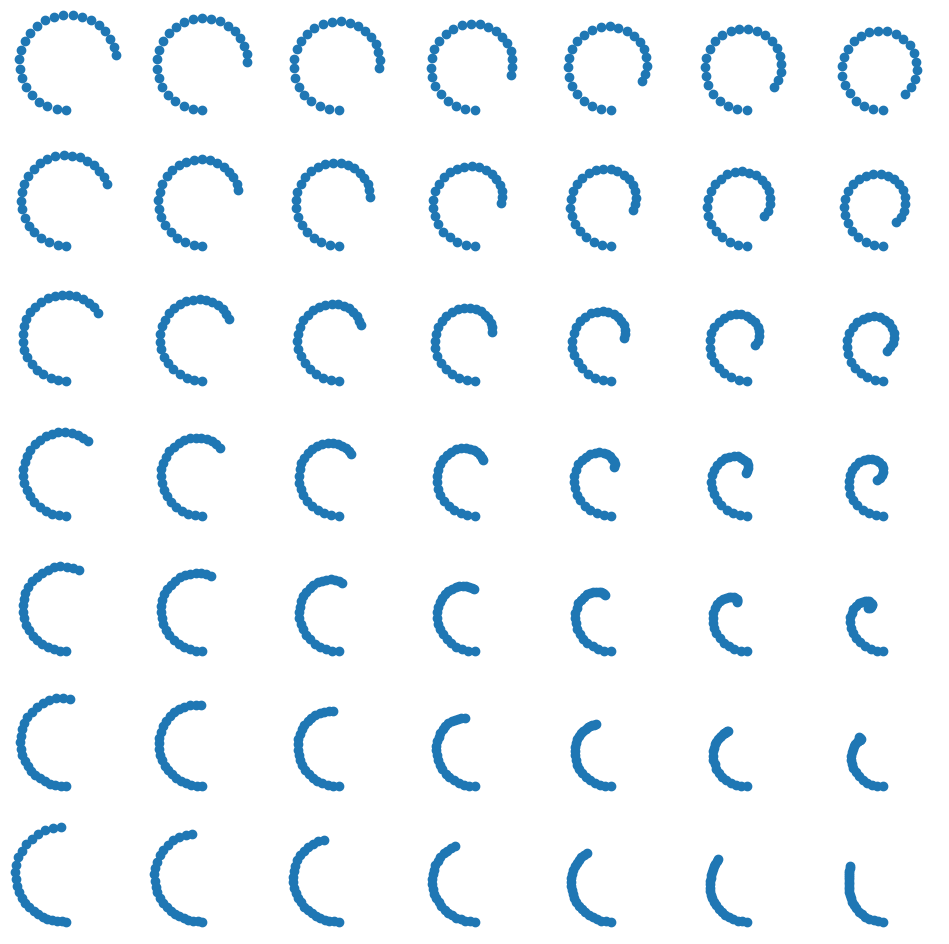

In [17]:
num_steps = 7
steps = torch.linspace(-1,1,num_steps)
shapes = []

for ev1 in steps:
    for ev2 in steps:
        b[0] = ev1 * torch.sqrt(eigenvalues_[0])
        b[1] = ev2 * torch.sqrt(eigenvalues_[1])
        appr_shape = mean_shape + torch.matmul(eigenvectors_, b)
        appr_shape = appr_shape.reshape(-1,2)
        shapes.append(appr_shape)


fig, ax = plt.subplots(num_steps, num_steps, figsize=(12, 12))
for i in range(num_steps):
    for j in range(num_steps):
        ax[i, j].scatter(shapes[i*num_steps+j][:,0], shapes[i*num_steps+j][:,1])
        ax[i, j].set_xlim(0,256)
        ax[i, j].set_ylim(0,256)
        ax[i, j].set_aspect('equal', adjustable='box')
        ax[i, j].invert_yaxis()
        ax[i, j].axis('off')
plt.show()


In [18]:
#create a gif with original segmentations

seg.shape

# import imageio
# imageio.mimsave('../visual_results/original_seg_ring.gif', [seg[i].squeeze()*255 for i in range(50)], duration=0.3)

torch.Size([50, 256, 256, 1])

In [19]:
#choose trained model
seg = torch.load('/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/data/disc_example_img.pth').permute(0, 2, 3, 1)

#model_path = '/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/results/19-dutiful-sky'
model_path = '/home/grossbroehmer/storage/staff/fenjafalta_658025/INR-SSM/results/112-frightful-shadow/'
#read config in args.json
with open(os.path.join(model_path, 'args.json'), 'r') as f:
    args = json.load(f)

#initialize model
#def __init__(self,in_features, out_features, hidden_ch=256,scale=30,num_layers=3):

if args['model'] == 'SirenModulated':
    model = SirenModulated(in_features=2+args['codebook_sz'], out_features=1, hidden_ch=args['channels'], num_layers=args['layers'])
else:

    model = Siren(in_features=2+args['codebook_sz'], out_features=1, hidden_ch=args['channels'], num_layers=args['layers'])
#load model
optimized_data = torch.load(os.path.join(model_path, f'model_{str(args["epochs"]-1)}.pth'))
model.load_state_dict(optimized_data['model'])

latent_codes = optimized_data['codebook'].detach().cpu()
N = args['num_samples']
H,W,C = seg.shape[-3:]
mesh = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W))

/home/grossbroehmer/mambaforge/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


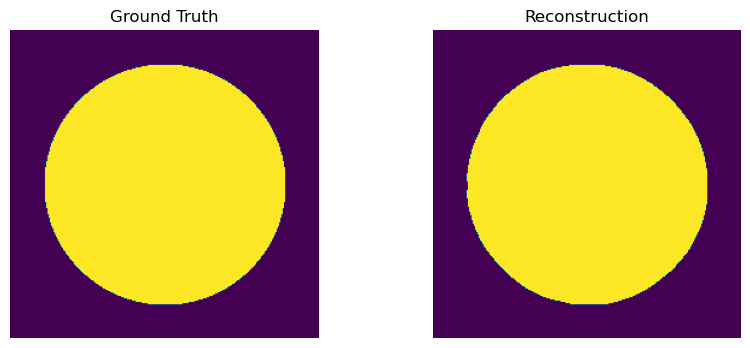

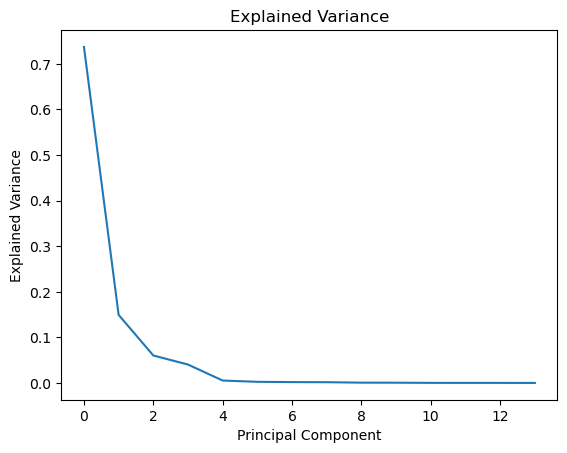

In [20]:
with torch.no_grad():
    out = model(torch.cat([mesh.view(-1,2), latent_codes[0].unsqueeze(0).repeat(H*W,1)], dim=-1)).view(H,W,1)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(seg[0,:,:].sum(-1))
ax[0].title.set_text('Ground Truth')
ax[1].imshow((out[:,:]<0).sum(-1).cpu())
ax[1].title.set_text('Reconstruction')
for a in ax:
    a.axis('off')
plt.show()


mean_shape = latent_codes.mean(dim=0)

cov_matrix = torch.matmul((latent_codes - mean_shape).T, (latent_codes - mean_shape)) / latent_codes.shape[0]

eigenvalues_, eigenvectors_ = torch.linalg.eig(cov_matrix)

eigenvalues_, indices = torch.sort(eigenvalues_.float(), descending=True)
eigenvectors_ = eigenvectors_[:, indices].float()


plt.plot(eigenvalues_/eigenvalues_.sum())
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance')
plt.show()

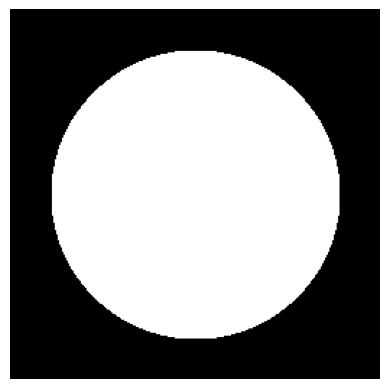

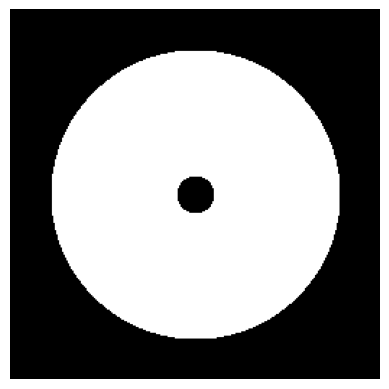

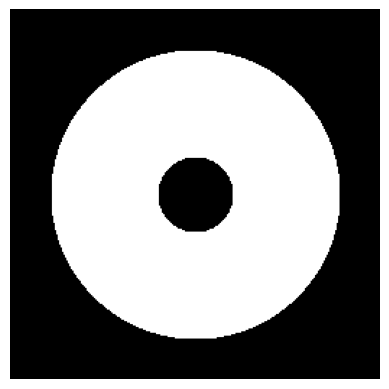

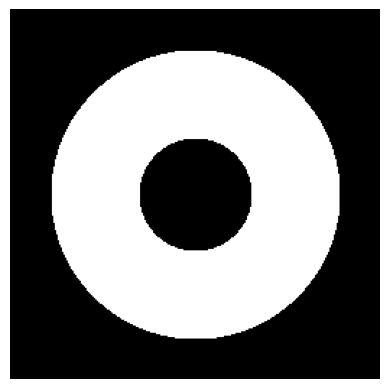

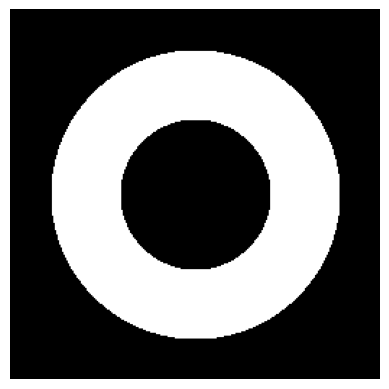

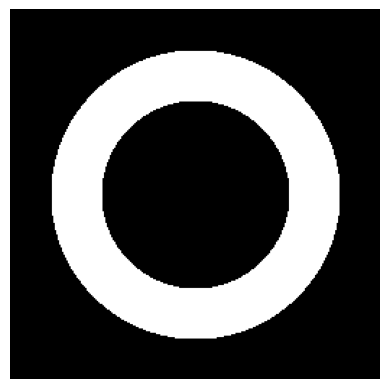

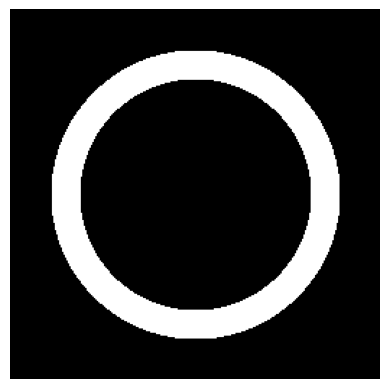

In [21]:
#save these frames as images
for ii,i in enumerate(np.linspace(0, 49, 7).astype(int)):
    plt.imshow(seg[i], 'gray')
    plt.axis('off')
    plt.savefig(f'/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/toy_example2/disc_example_{ii}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()
    plt.close()



In [22]:

num_steps = 7
steps = torch.linspace(-1.8,1.8,num_steps)
b = torch.zeros(latent_codes.shape[1])
images_seg_ring = []

for ii,ev1 in enumerate(steps):

    b[0] = ev1 * torch.sqrt(eigenvalues_[0])
    latent_code = mean_shape + torch.matmul(eigenvectors_, b)
    
    with torch.no_grad():
        out = model(torch.cat([mesh.view(-1,2), latent_code.unsqueeze(0).repeat(H*W,1)], dim=-1)).view(H,W,1)
        out = (out[:,:]<0).sum(-1).cpu()
    images_seg_ring.append(out)

    #save these frames as images
    plt.imshow(out, 'gray')
    plt.axis('off')
    plt.savefig(f'/home/grossbroehmer/storage/staff/christophgrossbroeh/projects/INR-SSM/toy_example2/disc_example_recon{ii}.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()
    print(ev1)

tensor(-1.8000)
tensor(-1.2000)
tensor(-0.6000)
tensor(5.9605e-08)
tensor(0.6000)
tensor(1.2000)
tensor(1.8000)


In [182]:
num_steps = 50
steps = torch.linspace(-1.4,1.4,num_steps)
b = torch.zeros(latent_codes.shape[1])
images = []

for ev1 in steps:

    b[0] = ev1 * torch.sqrt(eigenvalues_[0])
    latent_code = mean_shape + torch.matmul(eigenvectors_, b)
    
    with torch.no_grad():
        out = model(torch.cat([mesh.view(-1,2), latent_code.unsqueeze(0).repeat(H*W,1)], dim=-1)).view(H,W,1)
        out = (out[:,:]<0).sum(-1).cpu()
    images.append(out)



In [23]:
# import imageio
# imageio.mimsave('../visual_results/pca_disc_inr_ev1.gif', [i.float()*255 for i in images], duration=0.3)